# Prediction Analysis

This notebook contains the code used to generate and visualize predictions for a subset of data.

In [ ]:
%%capture
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

import numpy as np
import csv
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as pyg
from torch.optim import Adam
from torch_geometric.data import Batch, Data
from torch_geometric.nn.conv import GATConv

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Select the dataset PEMS04 and set the seed to 0

In [5]:
dataset_name = "PEMS04"
dir = "/kaggle/input/pems-dataset/data/PEMS04"
seed = 0

In [30]:
pyg.seed_everything(seed)
    
npz_path = f"{dir}/{dataset_name}.npz"
csv_path = f"{dir}/{dataset_name}.csv"

with np.load(npz_path) as f:
    original_data = f['data']

with open(csv_path, 'r') as f:
    reader = csv.reader(f)
    edges = list(reader)

df = pd.DataFrame(edges[1:], columns=edges[0])
df['from'] = df['from'].astype(int)
df['to'] = df['to'].astype(int)
df['cost'] = df['cost'].astype(float)

edge_index = torch.tensor(df[['from', 'to']].values.T, dtype=torch.long)
edge_attr = torch.tensor(df['cost'].values, dtype=torch.float)

In [32]:
original_data = torch.from_numpy(original_data).float()

In [33]:
def normalize(data):
    mean = data.mean(dim=(0, 1), keepdim=True)
    std = data.std(dim=(0, 1), keepdim=True)
    return (data - mean) / std, mean, std

The model expects Z-standardized data (mean=0, std=1).

In [34]:
data, mean, std = normalize(original_data)

In [35]:
day_unit = int(24 * 60 / 5)

This defines the GAT-GRU model, which is a combination of GAT and GRU (with skip connection and dropout).

In [37]:
class GAT_GRU_Model(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_gru_layers=1, dropout=0.2):
        super(GAT_GRU_Model, self).__init__()
        self.gat = GATConv(in_channels, hidden_channels, dropout=dropout)
        self.skip_proj = nn.Linear(in_channels, hidden_channels)
        self.dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_channels, hidden_channels, num_layers=num_gru_layers, batch_first=False)
        self.fc = nn.Linear(hidden_channels, in_channels)

    def forward(self, inputs, edge_index, edge_attr, hidden_state=None):
        # (seq_len, batches, nodes, hidden_channels)
        seq_len = inputs.size(0)
        n_batch = inputs.size(1)
        n_nodes = inputs.size(2)

        seq_embeddings = []
        for seq in inputs:
            # (batches, nodes, hidden_channels)
            batch = Batch.from_data_list([
                Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
                for x in seq
            ])
            # (batches * nodes, hidden_channels) -> (batches * nodes, hidden_channels)
            node_embeddings = self.gat(batch.x, batch.edge_index, batch.edge_attr)
            skip_output = self.skip_proj(batch.x)
            node_embeddings = F.relu(node_embeddings + skip_output) # skip connection
            seq_embeddings.append(node_embeddings)

        # (seq_len, batches * nodes, hidden_channels)
        embeddings_output = torch.stack(seq_embeddings, dim=0)
        embeddings_output = self.dropout(embeddings_output)

        # (seq_len, batches * nodes, hidden_channels) -> (seq_len, batches * nodes, hidden_channels)
        gru_output, hidden_state = self.gru(embeddings_output, hidden_state)

        # (seq_len, batches * nodes, hidden_channels) -> (seq_len, batches, nodes, hidden_channels)
        output = gru_output.view((seq_len, n_batch, n_nodes, -1))

        # (seq_len, batches, nodes, hidden_channels) -> (seq_len, batches, nodes, out_channels)
        output = self.fc(output)
        return output, hidden_state

In [103]:
def denormalize(data):
    return data * std + mean

### 12 timesteps (60 minute horizon)

This sets up prediction using a 60 minute horizon. The target data is a 24-hour period, and the input data is the same length but shifted earlier by 12 timesteps.

In [112]:
steps = 12
day_data_12 = data[day_unit - steps:day_unit * 2]
model_path = "/kaggle/input/pems04-models/best_model_PEMS04_50epoch_12step_0seed.sav"
model12 = GAT_GRU_Model(in_channels=3, hidden_channels=16).to(device)
model12.load_state_dict(torch.load(model_path, map_location=torch.device(device)))

/tmp/ipykernel_24/825913049.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model12.load_state_dict(torch.load(model_path, map_location=torch.device(device)))


<All keys matched successfully>

The model gets 12 timesteps (60m) of data, which it uses to predict the next 12 timesteps. Then it uses the actual values of the next 12 timesteps to predict the 12 after that, and so on.

In [113]:
with torch.no_grad():
    model12.eval()
    preds12 = []
    for i in range(0, len(day_data_12), steps):
        input_data = day_data_12[i:i+steps].unsqueeze(1)
        target_data = day_data_12[i+steps:i+steps+steps].unsqueeze(1)
        output, hidden_state = model12(input_data.to(device), edge_index, edge_attr, hidden_state=None)
        for i in range(len(target_data)):
            if i == 0:
                current_data = input_data[-1].unsqueeze(0)
            else:
                current_data = output
            output, hidden_state = model12(current_data.to(device), edge_index, edge_attr, hidden_state)
            preds12.append(output.squeeze(0).to("cpu"))       

### 3 timesteps (15 minute horizon)

This sets up prediction using a 3 minute horizon.

In [114]:
steps = 3
day_data_3 = data[day_unit - steps:day_unit * 2]
model_path = "/kaggle/input/pems04-models/best_model_PEMS04_50epoch_3step_0seed.sav"
model3 = GAT_GRU_Model(in_channels=3, hidden_channels=16).to(device)
model3.load_state_dict(torch.load(model_path, map_location=torch.device(device)))

/tmp/ipykernel_24/1581701762.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model3.load_state_dict(torch.load(model_path, map_location=torch.device(device)))


<All keys matched successfully>

This works the same as the 12 timestep version, only here it is 3 timesteps.

In [115]:
with torch.no_grad():
    model3.eval()
    preds3 = []
    for i in range(0, len(day_data_3), steps):
        input_data = day_data_3[i:i+steps].unsqueeze(1)
        target_data = day_data_3[i+steps:i+steps+steps].unsqueeze(1)
        output, hidden_state = model3(input_data.to(device), edge_index, edge_attr, hidden_state=None)
        for i in range(len(target_data)):
            if i == 0:
                current_data = input_data[-1].unsqueeze(0)
            else:
                current_data = output
            output, hidden_state = model3(current_data.to(device), edge_index, edge_attr, hidden_state)
            preds3.append(output.squeeze(0).to("cpu"))       

Denormalize the predictions and targets so they can be properly displayed in the original scale.

In [127]:
predicted12 = np.array([denormalize(p) for p in preds12]).squeeze(1)
predicted3 = np.array([denormalize(p) for p in preds3]).squeeze(1)
true = np.array([denormalize(t) for t in day_data_3[3:]]).squeeze(1)

In [226]:
def plot_traffic(node, type):
    if type == 0:
        name = 'Flow'
    elif type == 1:
        name = 'Occupancy'
    elif type == 2:
        name = 'Speed'
    else:
        raise Exception("wrong type")
    p12 = predicted12[:, node, type]
    p3 = predicted3[:, node, type]
    t = true[:, node, type]
    time_range = range(0, day_unit)
    plt.plot(time_range, p12, label='Predicted Traffic (60m horizon)')
    plt.plot(time_range, p3, label='Predicted Traffic (15m horizon)')
    plt.plot(time_range, t, label='Actual Traffic', alpha=0.5)
     
    # plt.title(f'Traffic {name} Prediction at Node {node}')

    hours = [f"{hour}:00" for hour in range(0, 24, 4)] + ["0:00"]
    hourly_positions = np.arange(0, len(t) + 1, 48)

    plt.xticks(hourly_positions, hours)
    
    plt.legend(loc='best')
    plt.savefig(f'{name.lower()}_{node}.png', bbox_inches="tight")
    plt.show()
    plt.close()

### Plots

Below are the various plots. Notice that the 3 timestep version is better at predicting traffic than the 12 timestep version, but both struggle with sharp peaks/troughs or unexpected data outliers.

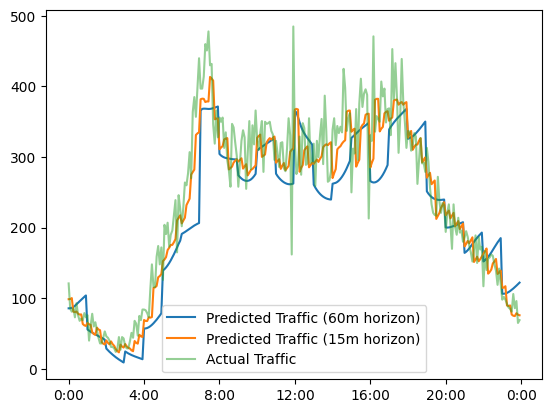

In [228]:
plot_traffic(0, 0) # Flow at node 0

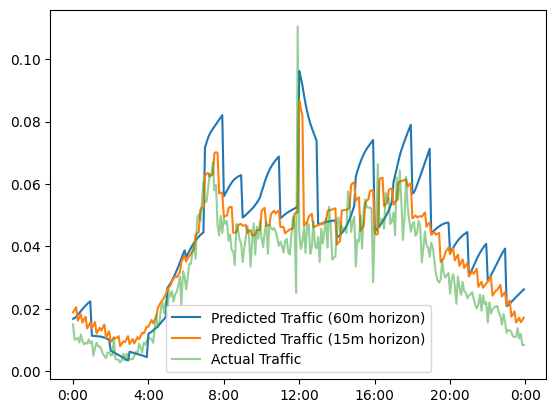

In [229]:
plot_traffic(0, 1) # Occupancy at node 0

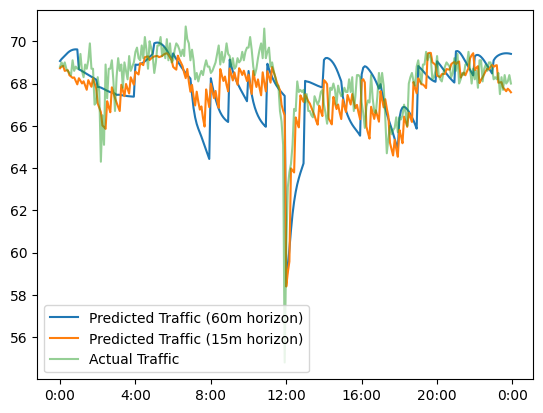

In [230]:
plot_traffic(0, 2) # Speed at node 0

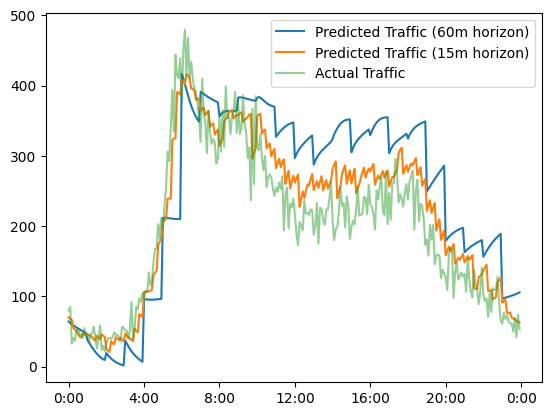

In [231]:
plot_traffic(1, 0) # Flow at node 1

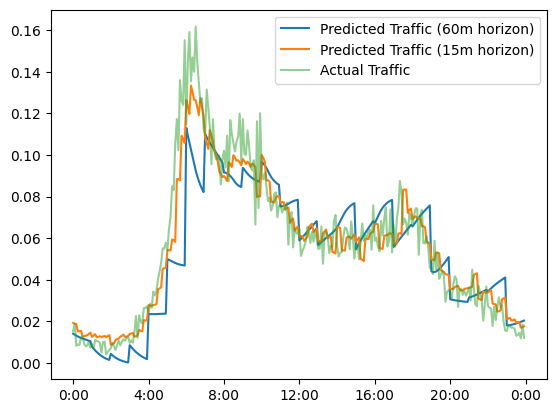

In [232]:
plot_traffic(1, 1) # Occupancy at node 1

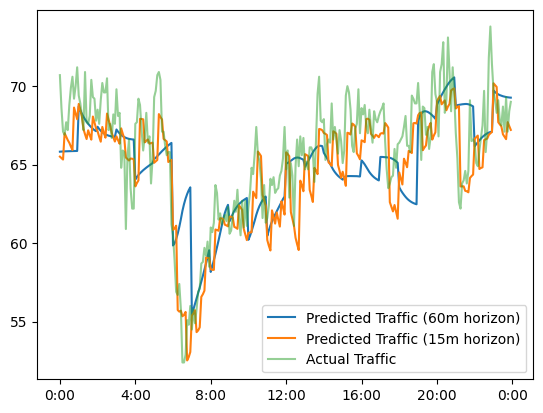

In [233]:
plot_traffic(1, 2) # Speed at node 1